# O->P model



- noise to weight implemented
- Pretrain attractor implementing

## Master config

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE", '\n')
!ls

# Becareful on the variable type in each cfg setting
# Do not use integer (e.g., 1, 2, 3, 0) in those variables
# that can be float32 (e.g., w_oh_noise, tau...)
# Use integer with a dot instead (e.g., 1., 2., 3., 0.)
from misc import model_cfg

cfg = model_cfg(code_name='RNN_v0.58', 
                sample_name='hs04', 
                sample_rng_seed=303,
                hidden_units=150, 
                pho_units=250, 
                cleanup_units=50,
                embed_attractor='p_task_v0.02',
                w_oh_noise=0.,
                w_hp_noise=0.,
                w_pp_noise=4.,
                w_pc_noise=4.,
                w_cp_noise=4.,
                act_p_noise=0.,
                tau=0.2, 
                unit_time=4., 
                n_mil_sample=1., 
                batch_size=128, 
                rnn_activation = 'sigmoid',
                w_initializer = 'glorot_uniform',
                learning_rate=0.01,
                save_freq=5)


GPU is available 

basicO2P_master.ipynb  input	my_eval.py
custom_layer.py        misc.py	pho_task_master.ipynb
data_wrangling.py      models	__pycache__


# Modeling

## Build model
Fully custom 4-layer recurrent time-averaged input

In [3]:
def buildModel(training=True):
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Layer, Input
    from custom_layer import rnn
    from tensorflow.keras.optimizers import Adam

    # Train/test mode checking
    if training is True:
        cfg.w_oh_noise = cfg.w_oh_noise_backup
        cfg.w_hp_noise = cfg.w_hp_noise_backup
        cfg.w_pp_noise = cfg.w_pp_noise_backup
        cfg.w_pc_noise = cfg.w_pc_noise_backup
        cfg.w_cp_noise = cfg.w_cp_noise_backup
        cfg.act_p_noise = cfg.act_p_noise_backup
    else:
        cfg.w_oh_noise = 0
        cfg.w_hp_noise = 0
        cfg.w_pp_noise = 0
        cfg.w_pc_noise = 0
        cfg.w_cp_noise = 0
        cfg.act_p_noise = 0

    input_o = Input(shape=(119,))
    rnn_model = rnn(cfg)(input_o)
    model = Model(input_o, rnn_model)

    adam = Adam(learning_rate=cfg.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['BinaryAccuracy', 'mse'])

    model.summary()

    return model

model = buildModel(training=True)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 119)]             0         
_________________________________________________________________
rnn (rnn)                    [(1, 250), (None, 250), ( 143300    
Total params: 143,300
Trainable params: 143,300
Non-trainable params: 0
_________________________________________________________________


## Arm attractor

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pho_task_input (InputLayer)  [(None, 250)]             0         
_________________________________________________________________
rnn (rnn_pho_task)           [(None, 250), (None, 250) 162950    
Total params: 162,950
Trainable params: 87,800
Non-trainable params: 75,150
_________________________________________________________________
rnn_1/w_pp:0 (250, 250)
rnn_1/w_pc:0 (250, 50)
rnn_1/w_cp:0 (50, 250)
rnn_1/bias_p:0 (250,)
rnn_1/bias_c:0 (50,)
rnn_1/w_oh:0 (250, 150)
rnn_1/w_hp:0 (150, 250)
rnn_1/bias_h:0 (150,)


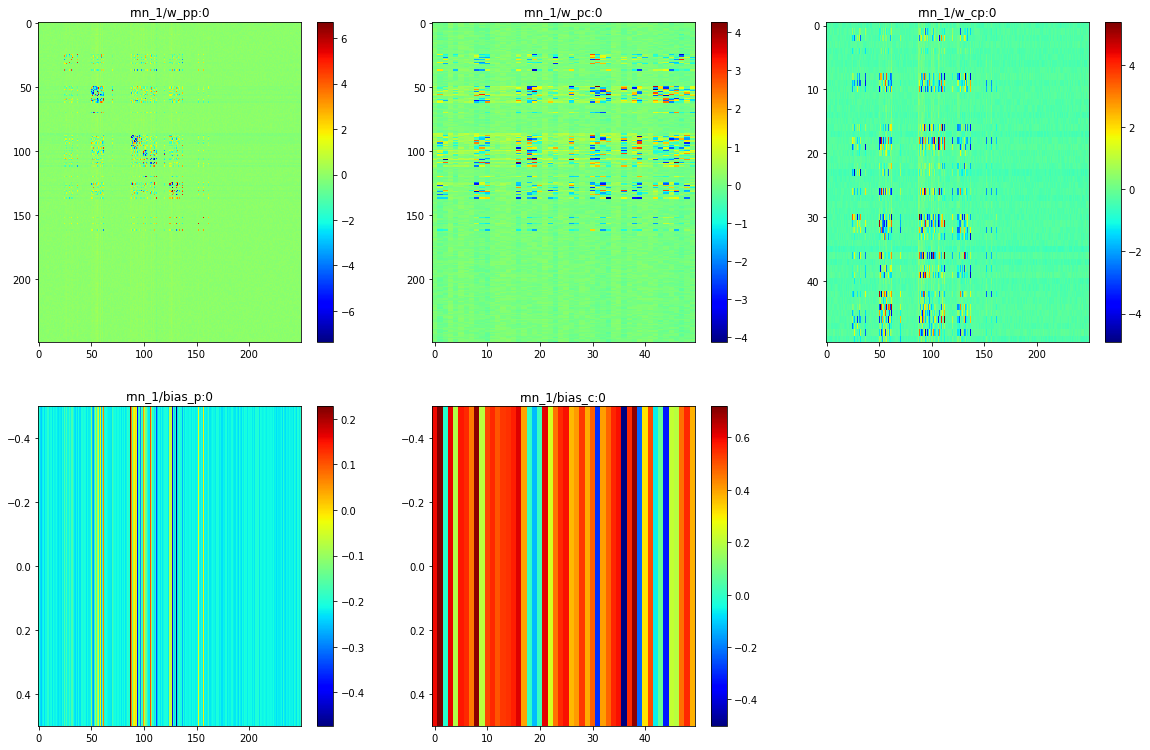

In [6]:
from misc import attractor
attractor = attractor(cfg, 'models/p_task_v0.02/model.h5')

names = [weight.name for weight in model.get_layer('rnn').weights] 
weights = model.get_weights()

n_matrices = len(model.get_layer('rnn').weights)
new_weights = []
for i in range(n_matrices):
    # Align model and attractor weight matrices
    
    # Get attractor value if weight matrix name match attractor 
    if model.get_layer('rnn').weights[i].name.endswith('w_pp:0'):
        new_weights.append(attractor.pretrained_w_pp)

    if model.get_layer('rnn').weights[i].name.endswith('w_pc:0'): 
        new_weights.append(attractor.pretrained_w_pc)
        
    if model.get_layer('rnn').weights[i].name.endswith('w_cp:0'): 
        new_weights.append(attractor.pretrained_w_cp)
        
    if model.get_layer('rnn').weights[i].name.endswith('bias_p:0'): 
        new_weights.append(attractor.pretrained_bias_p)
        
    if model.get_layer('rnn').weights[i].name.endswith('bias_c:0'): 
        new_weights.append(attractor.pretrained_bias_c)
    
    # Fill original value if this slot have not been filled
    if len(new_weights) < i + 1:
        new_weights.append(model.get_weights()[i])

# new_weights

model.set_weights(new_weights)

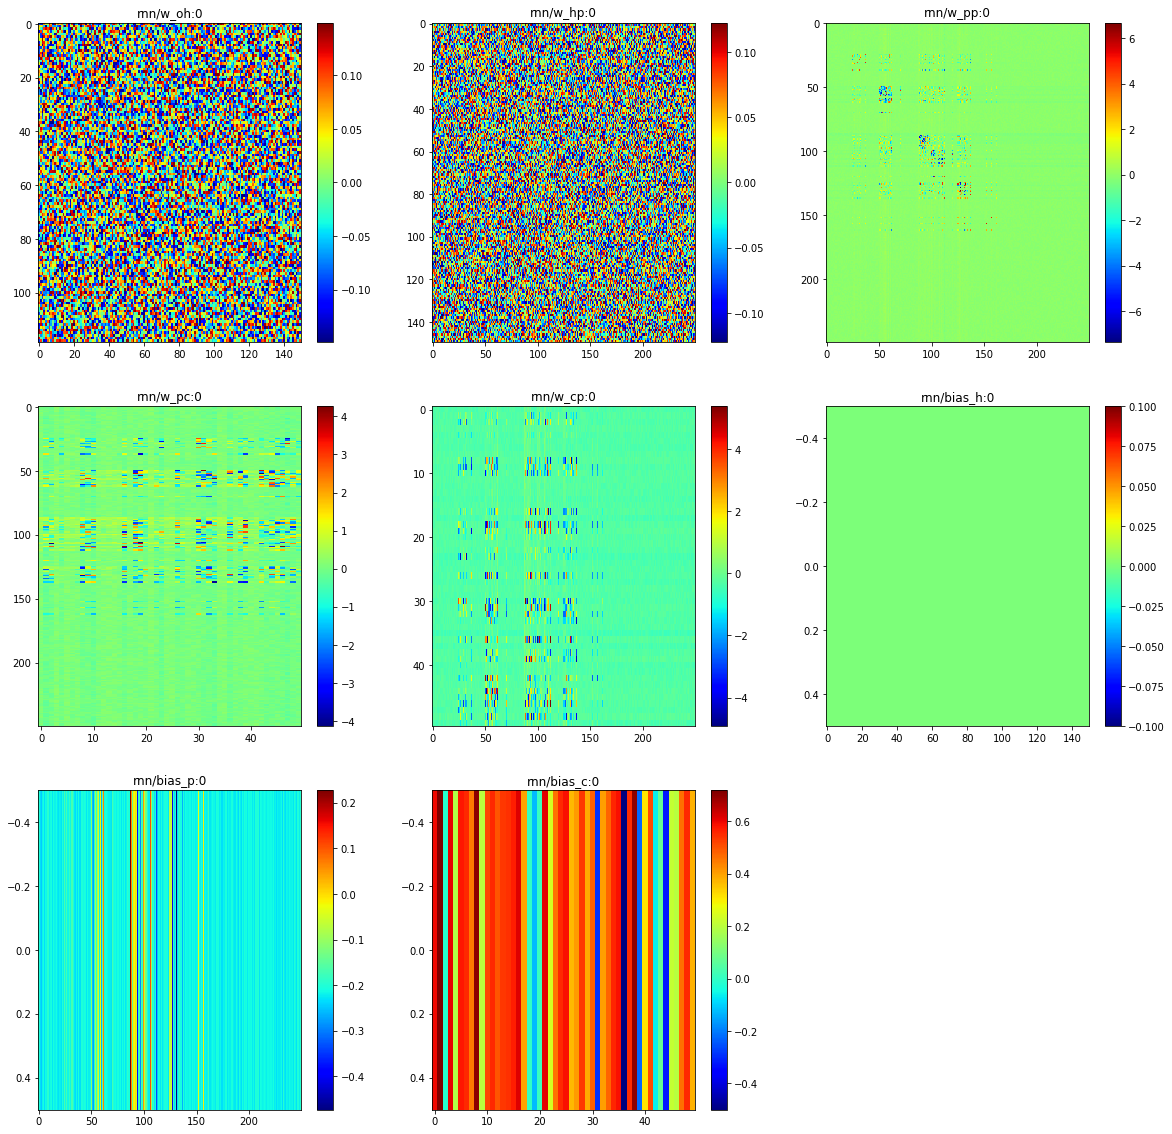

In [8]:
# Sanity check again...

from misc import plot_variables
plot_variables(model)

## Train model

In [9]:
from keras.callbacks import ModelCheckpoint
from data_wrangling import sampleGenerator
import h5py, pickle, os
from IPython.display import clear_output

from misc import my_data
data = my_data(cfg)

checkpoint = ModelCheckpoint(cfg.path_weights_checkpoint, verbose=1, 
                             period=cfg.save_freq, save_weights_only=True) 

history = model.fit(sampleGenerator(data.x_train, data.y_train, 
                                    cfg.n_timesteps, cfg.batch_size, 
                                    data.sample_p, cfg.sample_rng_seed),
                                    steps_per_epoch = cfg.steps_per_epoch,
                                    epochs = cfg.nEpo,
                                    verbose=0,  
                                    callbacks=[checkpoint])

# Saving history and model
pickle_out = open(cfg.path_history_pickle,"wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

clear_output()
print('Training done')

Training done


# Reporting

Training history

In [10]:
from my_eval import training_history

hist = training_history(cfg.path_history_pickle)
hist.plot_all(cfg.path_plot_folder + 'history.html')

alt.HConcatChart(...)

### Critical note when model contain noise
- Must recompile model with zero noise during eval

In [11]:
model = buildModel(training=False)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 119)]             0         
_________________________________________________________________
rnn_1 (rnn)                  [(1, 250), (None, 250), ( 143300    
Total params: 143,300
Trainable params: 143,300
Non-trainable params: 0
_________________________________________________________________


## Strain

In [12]:
from my_eval import strain, grain

strain = strain(model, cfg, data)
strain.start_evaluate()

sdev = strain.plot_development()
stim = strain.plot_time_course()

s = sdev & stim

s.save(cfg.path_plot_folder + 'strain_plots.html')
s


All done


alt.VConcatChart(...)

## Grain
Terminology remarks:
- Condition
    - Ambiguous = Experimental = Critical
    - Unambiguous = Control
- Response
    - Large grain = decode using context
    - Small grain = decode using GPC

In [13]:
from my_eval import grain

grain = grain(model, cfg, data)
grain.start_evaluate()

gdev = grain.plot_development()
gtim = grain.plot_time_course()

g = gdev & gtim
g.save(cfg.path_plot_folder + 'grain_plots.html')
g

Done


alt.VConcatChart(...)

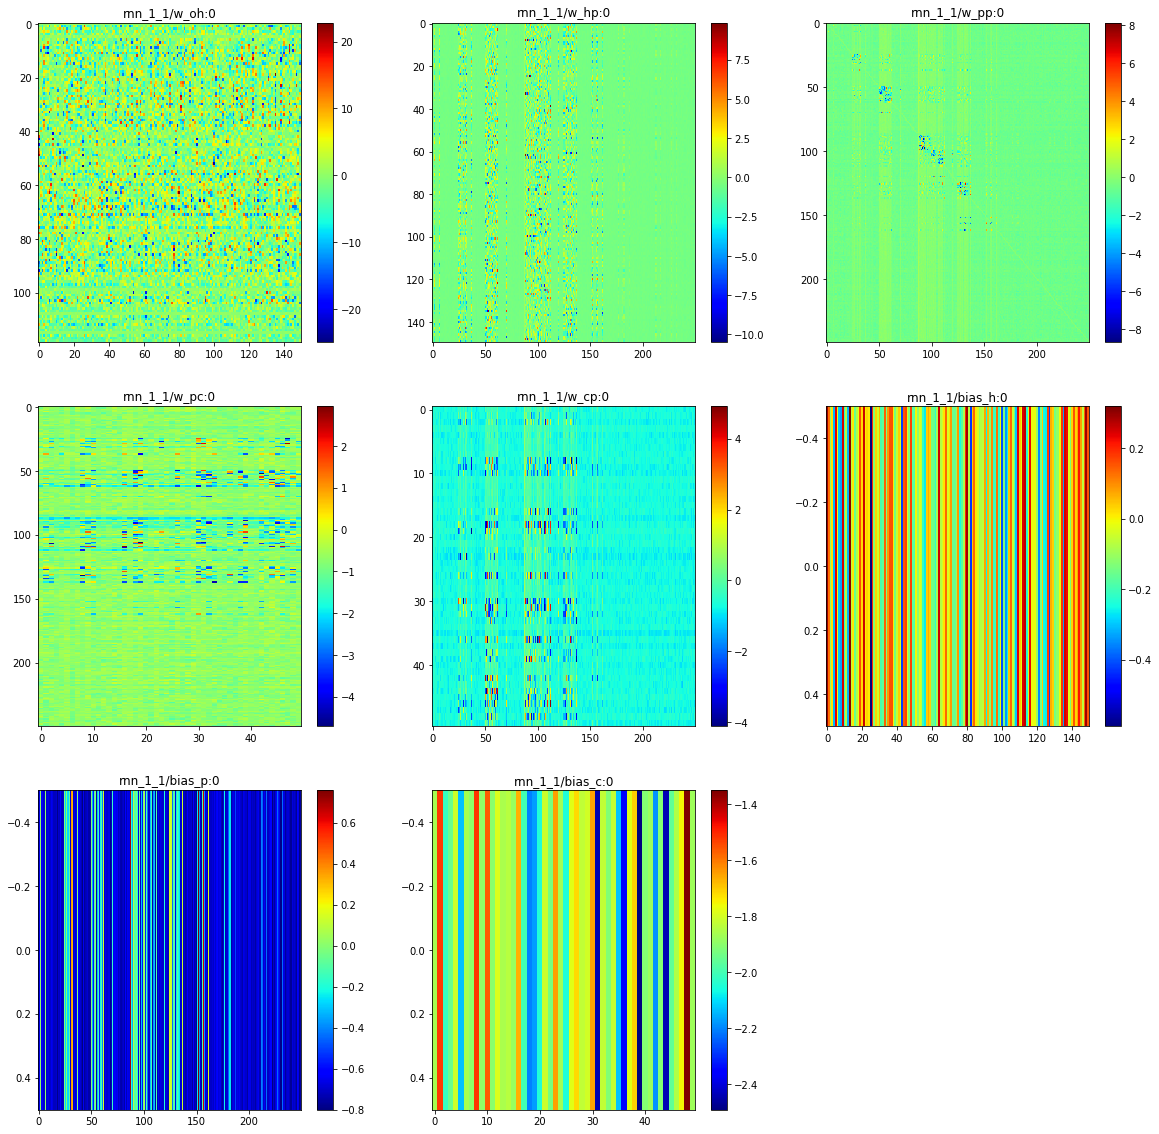

In [14]:
from misc import plot_variables
plot_variables(model)

# Dev zone

In [ ]:
# Grab all config history from bq_table
bq_table_cfg = 'batch_test.cfg'
sql =  """SELECT * FROM `""" + bq_table_cfg + """`"""
df = pandas_gbq.read_gbq(sql, project_id=project_id)

In [ ]:
# Copy csv file to CSV ingest bucket



file_name = 'models/RNN_v0.42_test/result_grain_epoch.csv'
project_id = 'idyllic-web-267716'
bucket_name = 'rnn_ingest'
!gsutil cp -r {file_name} gs://{bucket_name}/ 
    
# Maybe just use pandas_gbq... much easier...

In [ ]:
# Create ingest CSV job for bigquery
from google.cloud import bigquery
client = bigquery.Client()
table_ref = client.dataset('batch_test').table('strain_epoch')

job_config = bigquery.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND
job_config.skip_leading_rows = 1
job_config.source_format = bigquery.SourceFormat.CSV

uri = "gs://rnn_ingest/*"
load_job = client.load_table_from_uri(uri, table_ref, job_config=job_config)
print("Starting job {}".format(load_job.job_id))

load_job.result()  # Waits for table load to complete.
print("Job finished.")

destination_table = client.get_table(table_ref)
print("Loaded {} rows.".format(destination_table.num_rows))
    

try https://github.com/keras-team/keras-tuner


In [ ]:
!pip install -U keras-tuner
from kerastuner.tuners import RandomSearch


## Item level plots

In [ ]:
# Strain item

sel = alt.selection(type='single', on='click', fields=['word'], empty='all')

strain_chart_items = alt.Chart(result_strain_items[lambda df: df['epoch'] == nEpo]
                               ).add_selection(sel).mark_line(point=True).encode(
    y='sse',
    x='unit_time',
    color = 'word',
    opacity = alt.condition(sel, alt.value(1), alt.value(0)),
    column = 'frequency',
    row = 'pho_consistency',
    tooltip=['epoch', 'word', 'pho', 'output', 'acc', 'sse']
    )


strain_chart_items

In [ ]:
 def plot_development_item(self, plot_time_step=None):
        import altair as alt
        if plot_time_step is None: plot_time_step = self.cfg.n_timesteps - 1

        
        sel = alt.selection(type='single', on='click', fields=['word'], empty='all')

        strain_chart_items = alt.Chart(result_strain_items[lambda df: df['timestep'] == n_timesteps - 1]
                                    ).add_selection(sel).mark_line(point=True).encode(
            y='sse',
            x='epoch',
            color = 'word',
            opacity = alt.condition(sel, alt.value(1), alt.value(0)),
            column = 'frequency',
            row = 'pho_consistency',
            tooltip=['epoch', 'word', 'pho', 'output', 'acc', 'sse']
            )


        strain_chart_items.save(plotsPath + 'strain_chart_items.html')
        strain_chart_items

In [ ]:
sel = alt.selection(type='single', on='click', fields=['word'], empty='all')

base = alt.Chart(result_grain_items[lambda df: df['epoch'] == nEpo]
                 ).add_selection(sel).mark_line(point=True).encode(
    x='unit_time',
    color = 'word',
    column = 'condition', 
    opacity = alt.condition(sel, alt.value(1), alt.value(0)),
    tooltip=['epoch', 'word', 'output', 'pho_large', 'pho_small', 'is_large_grain', 'is_small_grain']
    )

amb = base.encode(
    y='sse_large_grain'
    ).transform_filter(
    (datum.condition == 'ambiguous')
    )

unamb = base.encode(
    y='sse_small_grain'
    ).transform_filter(
    (datum.condition == 'unambiguous')
    )


grain_chart_items = amb | unamb
grain_chart_items.save(plotsPath + 'grain_chart_items.html')
grain_chart_items

In [ ]:
result_grain_items['unit_time'] = result_grain_items['timestep'] * tau

sel = alt.selection(type='single', on='click', fields=['word'], empty='all')

base = alt.Chart(result_grain_items[lambda df: df['epoch'] == nEpo]
                 ).add_selection(sel).mark_line(point=True).encode(
    y='sse_acceptable',
    x='unit_time',
    color = 'word',
    opacity = alt.condition(sel, alt.value(1), alt.value(0)),
    tooltip=['epoch', 'word', 'output', 'pho_large', 'pho_small', 'is_large_grain', 'is_small_grain']
    )

base


In [ ]:
sel = alt.selection(type='single', on='click', fields=['word'], empty='all')

base = alt.Chart(result_grain_items[lambda df: df['timestep'] == n_timesteps - 1]
                 ).add_selection(sel).mark_line(point=True).encode(
    y='sse_acceptable',
    x='epoch',
    color = 'word',
    opacity = alt.condition(sel, alt.value(1), alt.value(0)),
    tooltip=['epoch', 'word', 'output', 'pho_large', 'pho_small', 'is_large_grain', 'is_small_grain']
    )

base
